# Pneumonia Identification from chest scan images

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

---
### Project flow  

1) Importing the libraries and Loading the Images

2) Exploring the Images 

3) Transforming the Images

4) Creating the model Architecture

5) Training the Data

6) Evaluate the Model

7) Prediction over user input data 

Dataset URL : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## 1. Importing modules and Loading Images 

#### 1.1 Changing from norebook directory to main directory  

In [2]:
%pwd

'/home/vidya_venugopal_98/Pneumonia_Identification/notebook'

In [3]:
import os
os.chdir("../")

In [4]:
%pwd

'/home/vidya_venugopal_98/Pneumonia_Identification'

#### 1.2 Importing Modules 

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

#### 1.3 Data Ingestion from Google drive

In [6]:
root_dir = 'artifacts/data_ingestion'
source_URL = 'https://drive.google.com/file/d/1H2__1hEfsL8FHKQ8NM4nW-V9zC5Hph9T/view?usp=drive_link'
local_data_file = 'artifacts/data_ingestion/data.zip'
unzip_dir = 'artifacts/data_ingestion'

In [7]:
import gdown
import zipfile

In [8]:
class DataIngestion:
    def download_file(self)->str:

            dataset_url = source_URL
            zip_download_dir = local_data_file
            os.makedirs("artifacts/data_ingestion", exist_ok=True)

            file_id = dataset_url.split("/")[-2]
            prefix = "https://drive.google.com/uc?/export=download&id="
            gdown.download(prefix+file_id,zip_download_dir)


    def extract_zip_file(self):
        unzip_path = unzip_dir
        os.makedirs(unzip_path, exist_ok=True)
        with zipfile.ZipFile(local_data_file, 'r') as zip_ref:
            zip_ref.extractall(unzip_path)

#### 1.4 Data Ingestion Pipeline

In [9]:
data_ingestion = DataIngestion()
data_ingestion.download_file()
data_ingestion.extract_zip_file()

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1H2__1hEfsL8FHKQ8NM4nW-V9zC5Hph9T
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1H2__1hEfsL8FHKQ8NM4nW-V9zC5Hph9T&confirm=t&uuid=5a547c41-5429-4741-ad60-1744dd3afdf4
To: /home/vidya_venugopal_98/Pneumonia_Identification/artifacts/data_ingestion/data.zip
100%|██████████| 444M/444M [00:03<00:00, 146MB/s]  


#### 1.5 Path of data after data ingestion

In [10]:
data_path = "artifacts/data_ingestion/chest_xray_m"

## 2. Exploring images and Transformations

#### 2.1 Strength of training and testing data in both classes

In [11]:
class_name = ['NORMAL','PNEUMONIA']

def get_pics_as_list(dir_name):

    files_list = os.listdir(dir_name)
    return files_list

files_list_normal_train = get_pics_as_list(data_path+'/train/'+class_name[0])
files_list_pneumonia_train = get_pics_as_list(data_path+'/train/'+class_name[1])
files_list_normal_test = get_pics_as_list(data_path+'/test/'+class_name[0])
files_list_pneumonia_test = get_pics_as_list(data_path+'/test/'+class_name[1])

In [12]:
print(f"Number of train samples in Normal category {len(files_list_normal_train)}")
print(f"Number of train samples in Pneumonia category {len(files_list_pneumonia_train)}")
print(f"Number of test samples in Normal category {len(files_list_normal_test)}")
print(f"Number of test samples in Pneumonia category {len(files_list_pneumonia_test)}")

Number of train samples in Normal category 300
Number of train samples in Pneumonia category 300
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


#### 2.2 Visualising a random image - train - Normal

Shape of normal image (train) =  (1650, 2136)


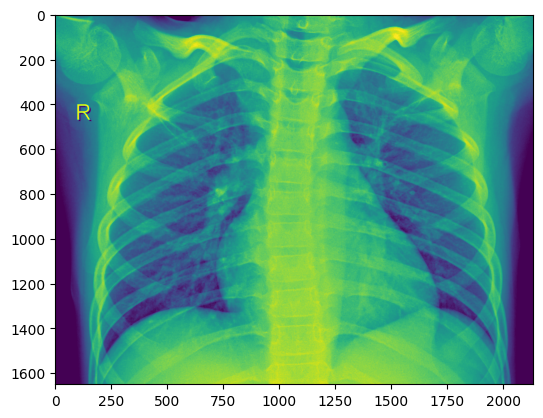

In [13]:
rand_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_no]
print("Shape of normal image (train) = ",plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

#### 2.3 Visualising a random image - train - Pneumonia

Shape of pneumonia image (train) =  (1504, 1568)


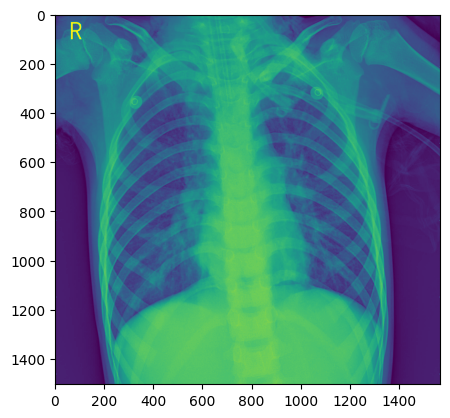

In [14]:
rand_no = np.random.randint(0,len(files_list_pneumonia_train))
img = data_path + '/train/PNEUMONIA/'+ files_list_pneumonia_train[rand_no]
print("Shape of pneumonia image (train) = ",plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

### Insights

- When above cell runs mutiple times, it is obvious that the images are of different shapes for the 'NORMAL' and 'PNEUMONIA' images in the **train** folder.

#### 2.4 Visualising a random image - test - Normal

Shape of normal image (test) =  (1725, 2001)


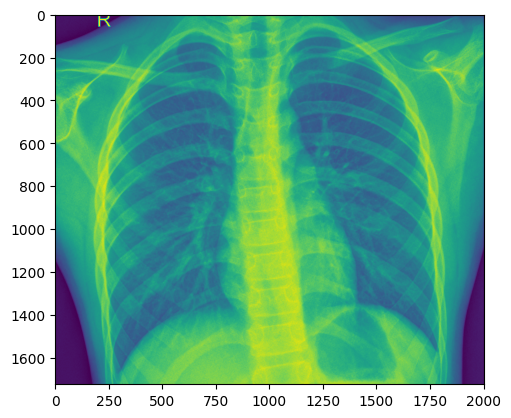

In [15]:
rand_no = np.random.randint(0,len(files_list_normal_test))
img = data_path + '/test/NORMAL/'+ files_list_normal_test[rand_no]
print("Shape of normal image (test) = ",plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

#### 2.5 Visualising a random image - test - Pneumonia

Shape of pneumonia image (test) =  (864, 1232)


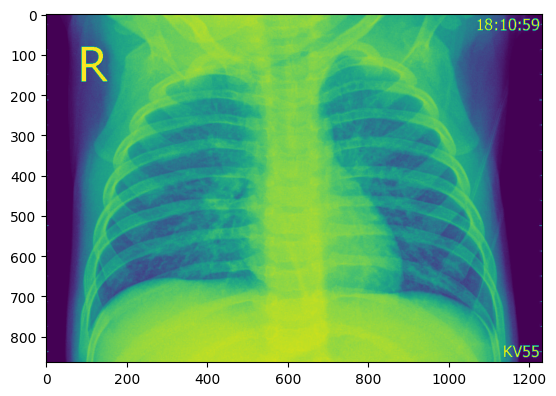

In [16]:
rand_no = np.random.randint(0,len(files_list_pneumonia_test))
img = data_path + '/test/PNEUMONIA/'+ files_list_pneumonia_test[rand_no]
print("Shape of pneumonia image (test) = ",plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

### Insights

- When above cell runs mutiple times, it is obvious that the images are of different shapes for the 'NORMAL' and 'PNEUMONIA' images in the **test** folder.

## 3. Transformation of images

- We need to perform transformation on both train and test images
- For Training data we need to perform the data augmentation also.
- Data Augmentation is done to create synthetic data.

In **Transformation** we are doing Resize,CenterCrop,ColorJitter,RandomHorizontalFlip,RandomRotation,ToTensor and Normalize.

1. Resize:- Resize the image to the given size.
2. CenterCrop:- Crops the given image at the center.
3. ColorJitter:- Randomly change the brightness, contrast, saturation and hue of an image.
4. RandomHorizontalFlip:- Horizontally flip the given image randomly with a given probability.
5. RandomRotation:- Rotate the image by angle.
6. ToTensor:- Convert numpy.ndarray to tensor.
7. Normalize:- Normalize a float tensor image with mean and standard deviation.

#### 3.1 Predefining parameters for transformations

In [17]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

#### 3.2 Saving the parameters in pickle file

In [18]:
import joblib
os.makedirs('models_m',exist_ok=True)

In [19]:
joblib.dump(train_transform, 'models_m/train_transforms_m.pkl')
joblib.dump(test_transform, 'models_m/test_transform_m.pkl') 

['models_m/test_transform_m.pkl']

#### 3.3 Loading data using PyTorch

In [20]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 2, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,
                         batch_size= 2, shuffle= False, pin_memory= True)
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 600
Number of test images: 624


## 4. Creating Model Architecture

#### 4.1 Defining a class to create custom CNN architecture for Image classification

In [21]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        # Input Block
        self.convolution_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pooling11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convolution_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=20, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling22 = nn.MaxPool2d(2, 2)
        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pooling33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.convolution_block6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convolution_block9 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convolution_block_out = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=True),
        )
    def forward(self, x):
        x = self.convolution_block1(x)
        x = self.pooling11(x)
        x = self.convolution_block2(x)
        x = self.pooling22(x)
        x = self.convolution_block3(x)
        x = self.pooling33(x)
        x = self.convolution_block4(x)
        x = self.convolution_block5(x)
        x = self.convolution_block6(x)
        x = self.convolution_block7(x)
        x = self.convolution_block8(x)
        x = self.convolution_block9(x)
        x = self.gap(x)
        x = self.convolution_block_out(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

#### 4.2 Checking weather cuda is available in the system or not

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor :  {}".format(device)) 

Available processor cpu


### 4.3 Checking the model summary

In [23]:
model = Net().to(device)
summary(model, input_size=(3, 224, 224)) 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       224
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-4                       1,460
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  40
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-7                       210
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  20
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-10                      1,820
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 40
├─Sequential: 1-8                        --
|    └─Conv2d: 2-13                      672
|    └─ReLU: 2-14 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       224
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-4                       1,460
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  40
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-7                       210
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  20
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-10                      1,820
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 40
├─Sequential: 1-8                        --
|    └─Conv2d: 2-13                      672
|    └─ReLU: 2-14 

## 5. Training Data

#### 5.1 Defining functions for training and testing 

In [24]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    """
    Description: To train the model

    input: model,device,train_loader,optimizer,epoch

    output: loss, batch id and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
def test(model, device, test_loader):
    """
    Description: To test the model

    input: model, device, test_loader

    output: average loss and accuracy

    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

#### 5.2 Defining the params for training

In [25]:
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 2 

#### 5.3 Training the model 

In [26]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.5404671430587769 Batch_id=299 Accuracy=75.33: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]    


current Learning Rate:  0.01

Test set: Average loss: 0.5147, Accuracy: 506/624 (81.09%)

EPOCH: 1


Loss=0.054417915642261505 Batch_id=299 Accuracy=87.00: 100%|██████████| 300/300 [00:39<00:00,  7.68it/s] 


current Learning Rate:  0.01

Test set: Average loss: 1.0756, Accuracy: 437/624 (70.03%)



## 6. Evaluation of Model architecture performance

#### 6.1 Evaluationg loss and accuracy for training set and testing set 

Text(0.5, 1.0, 'Test Accuracy')

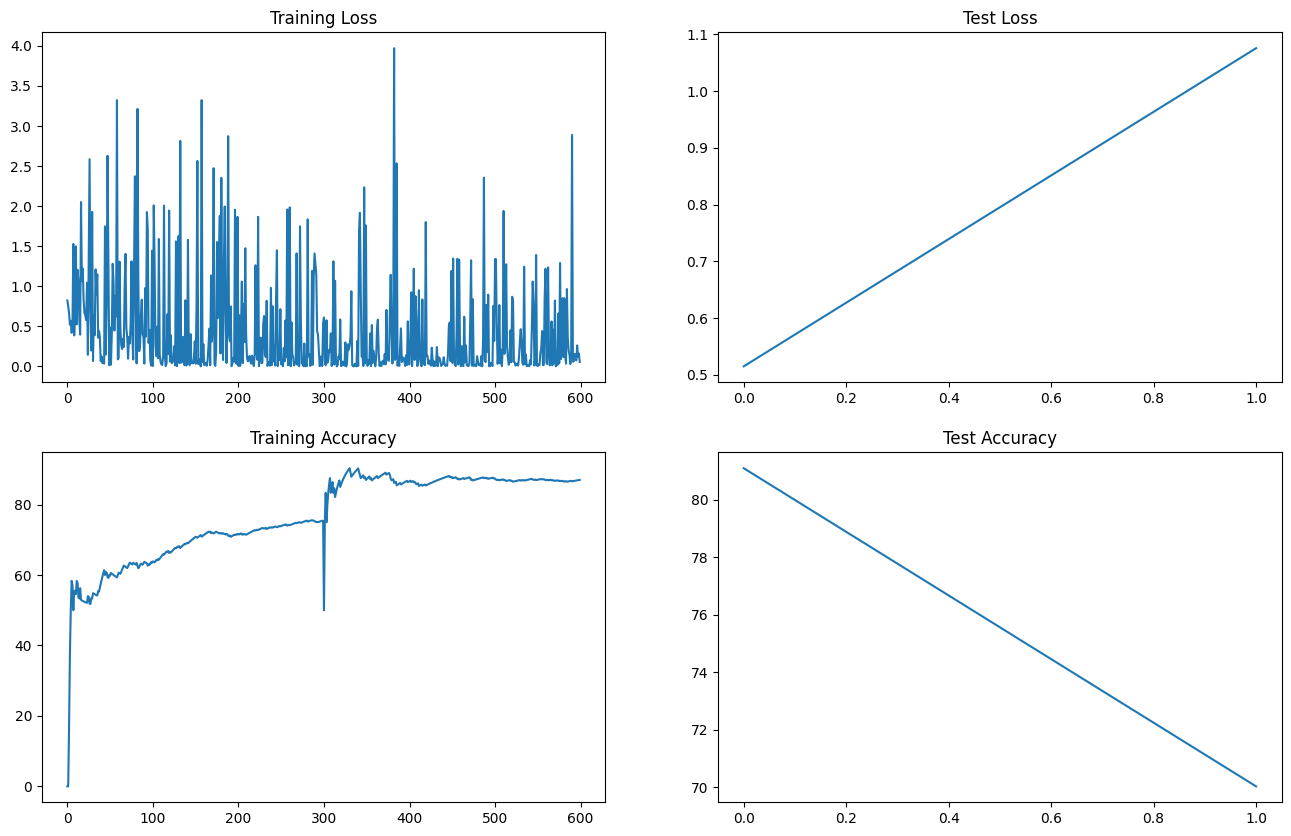

In [27]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

#### 6.2 Saving the trained model in .pt format 

In [28]:
os.makedirs('models_m', exist_ok=True) 

In [29]:
torch.save(model, 'models_m/trained_model_m.pt')

In [30]:
torch.save(model.state_dict(), "models_m/trained_model_dict.pt") 

## 7. Prediction on an input image 

In [31]:
import io
import numpy as np
import torch
from PIL import Image as PILImage  
import pickle 

In [32]:
PREDICTION_LABEL: dict = {0: "NORMAL", 1: "PNEUMONIA"} 

In [33]:
train_transforms = joblib.load(os.path.join('models','train_transforms.pkl')) 

In [34]:
img = Image.open('artifacts/data_ingestion/chest_xray_m/val/PNEUMONIA/person1947_bacteria_4876.jpeg')

# Create a BytesIO object
b = io.BytesIO()

# Save the image to the BytesIO object
img.save(b, format="JPEG")
im_bytes = b.getvalue()
image = PILImage.open(io.BytesIO(im_bytes)).convert("RGB") 

In [35]:
with open("models/train_transforms.pkl", "rb") as f:
    my_transforms = pickle.load(f) 

In [36]:
image = torch.from_numpy(np.array(my_transforms(image).unsqueeze(0)))
image = image.reshape(1, 3, 224, 224) 

In [37]:
model = torch.load("models/trained_model.pt")
model.eval() 

Net(
  (convolution_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pooling11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convolution_block2): Sequential(
    (0): Conv2d(8, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pooling22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convolution_block3): Sequential(
    (0): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pooling33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convolution_block4): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2

In [38]:
image_tensor = torch.tensor(image, dtype=torch.float32) 

/tmp/ipykernel_3617/3609688479.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32)


In [39]:
with torch.no_grad():
    output = model(image_tensor) 

In [40]:
prediction_index = torch.argmax(output, dim=1).item() 
pred = PREDICTION_LABEL[prediction_index]  

In [41]:
pred 

'PNEUMONIA'

python app.py 